## Homework 2
### Olivia Cooper
### Computational Astrophysics, Spring 2022

In [1]:
# the basics

import numpy as np
import numpy.ma as ma
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import astropy
from astropy.table import Table
import sod_exact
plt.style.use('cooper-paper.mplstyle')

# function to find closest value in array to specific number

def closest(lst, val):
    lst = np.asarray(lst) 
    idx = (np.abs(lst - val)).argmin() 
    return idx,lst[idx]

### Problem 1: Not so fast!

Use a perturbation analysis to show that the leapfrog scheme (time-centered
difference):

$\rho_j^{n+1} - \rho_j^{n-1} = -v_0 \frac{\Delta t}{\Delta x} (\rho_{j+1}^{n} - \rho_{j-1}^{n})$

is conditionally stable, i.e. it is stable as long as $\Delta t \leq \frac{\Delta x}{v_0}$. Assume that $v_0$ is a constant
velocity.

First, introduce the perturbation:

$\rho_j^n(k) = \xi_j^n e^{ikj\Delta x}$

Now, apply this to our leapfrog scheme and simplify.

$\xi_j^{n+1} e^{ikj\Delta x} - \xi_j^{n-1} e^{ikj\Delta x} =  \frac{-v_0\Delta t}{\Delta x} (\xi_{j+1}^{n} e^{ik(j+1)\Delta x} - \xi_{j-1}^{n} e^{ik(j-1)\Delta x})$

$\xi_j^{n+1}  - \xi_j^{n-1}  =  \frac{-v_0\Delta t}{\Delta x} (\xi_{j+1}^{n} e^{ik\Delta x} - \xi_{j-1}^{n} e^{-ik\Delta x})$

$\xi  - \xi^{-1}  =  \frac{-v_0\Delta t}{\Delta x} (e^{ik\Delta x} -  e^{-ik\Delta x})$

We know that $\xi$ is small, so the $1/\xi$ goes to zero. Now we can substitute in a sine function for the exponential terms.

$\xi  =  \frac{-v_0\Delta t}{\Delta x} (e^{ik\Delta x} -  e^{-ik\Delta x})$

$\xi  =  \frac{-v_0\Delta t}{\Delta x} (i sin(k\Delta x))$

We showed in class that in the case $||\xi||>1$, the perturbation grows with time and is unconditionally unstable. So, solve for $||\xi||\leq1$ to find when the scheme is conditionally stable.

$||\xi||  =  \left[\frac{v_0^2\Delta t^2}{\Delta x^2} (sin^2(k\Delta x))\right]^{1/2}$

The $sin^2(k\Delta x)$ term will oscillate from 0 to 1, with a maximum value of 1. Taking this maximum case, we can write our condition and simplify:

$\left[\frac{v_0^2\Delta t^2}{\Delta x^2}\right]^{1/2} \leq 1$

$\Delta t \leq \frac{\Delta x}{v_0}$

### Problem 2: Sod Shock Tube

Using the finite volume discretization given in class and a programming language
of your choice, write your own 1D hydrodynamic solver.

a) The quintessential shock benchmark problem is the “Sod Shock Tube” (first formulated
by Sod in 1978). The problem involves setting up two discontinuous states at $t = 0$: a hot
dense gas on the left and a cool, low-density gas on the right. The result is a shock wave
that travels left to right into the cold gas, and a rarefaction wave that travels into the dense
gas on the left.

Let the domain be [0,2], and set ρ1 = 1.0, p1 = 1.0 for x ≤0.75 and ρ2 = 0.125,
p2 = 0.1 for x > 0.75. Assume γ = 1.4 and use this to determine the specific energy. Set
v = 0 everywhere initially. Use symmetry boundary conditions and N = 200 grid cells. Set
the time step according to a CFL number of 0.5.

Compute the solution at t = 0.245 and make plots of the density, velocity, pressure and
specific energy as a function of position. Compare the shock properties (speed, density
jump, pressure jump, velocity) with that predicted for these conditions (e.g. see Stone &
Norman 1992).

In [11]:
def shock_tube_numerical(gamma=1.4,rhoL=1.,rhoR=0.125,prL=1.,prR=0.1,velL=0.,velR=0.,\
                         xL=0.,xi=0.75,xR=2.,CFL=0.5,N=200,q0=4,q1=0.5,tmax=0.245,verbose=True):

    # initialize arrays
    x_old = np.linspace(start=xL, stop=xR, num=N) # position, includes init cond for x
    dx_old = x_old[1:] - x_old[:-1] # grid spacing dx
    rho_old = np.zeros(N-1) # density
    vel_old = np.zeros(N) # velocity
    pr_old = np.zeros(N-1) # pressure
    qvisc_old = np.zeros(N-1) # artificial viscosity
    dt = 0.0001 # initial time step

    # apply initial conditions to the other arrays
    left = np.where(x_old[:-1] <= xi) # left side from shock interface 
    right = np.where(x_old[:-1] > xi) # right side from shock interface 

    rho_old[left] = rhoL; rho_old[right] = rhoR
    pr_old[left] = prL; pr_old[right] = prR
    en_old = pr_old/(rho_old*(gamma-1))
    cs_old = np.sqrt(gamma*pr_old/rho_old)
    dx_old = x_old[1:] - x_old[:-1]

    # set cell mass
    dm_i2 = 2*rho_old/N 
    dm_i = 0.5*(dm_i2[:-1]+dm_i2[1:])
    dm_i = np.pad(dm_i, (1,1), 'symmetric') 

    # plot the initial conditions we set as a sanity check
    if verbose==True:
        f, ax = plt.subplots(3, sharex=True, figsize=(8,8))

        ax[0].plot(x_old[1:], pr_old, 'm')
        ax[0].set_ylabel('pressure')
        ax[0].set_ylim(0, 1.1)
        ax[0].set_xlim(xL, xR)

        ax[1].plot(x_old[1:], rho_old, 'c')
        ax[1].set_ylabel('density')
        ax[1].set_ylim(0, 1.1)
        ax[1].set_xlim(xL, xR)

        ax[2].plot(x_old, vel_old, 'b')
        ax[2].set_ylabel('velocity')
        ax[2].set_xlim(xL, xR)

        plt.show()
    else:
        pass

    # initialize time and counter
    time = 0.0
    ct = 1
    
    # begin while loop
    while time < tmax:

        # boundary conditions, set edge velocities = 0
        vel_old[0], vel_old[-1] = 0., 0.

        if verbose==True:
            print("counter = ",ct)
        else:
            pass

        # solve for new velocity
        prpad = np.pad(pr_old, (1,1), 'symmetric') # pad edges to match array size to vel array
        qpad = np.pad(qvisc_old, (1,1), 'symmetric') # pad edges to match array size to vel array
        pr_diff = prpad[1:] - prpad[:-1]
        q_diff = qpad[1:] - qpad[:-1]
        vel_new = vel_old - dt*(pr_diff + q_diff)/dm_i

        # compute new grid positions
        x_new = x_old + dt*vel_new

        # compute new grid widths
        dx_new = x_new[1:] - x_new[:-1]

        # compute new density
        rho_new = dm_i2/dx_new

        # compute sound speed
        cs_new = np.sqrt(gamma*pr_old/rho_old)

        # compute artificial viscosity
        rho_avg = 0.5*(1/rho_old + 1/rho_new)
        vel_diff = vel_new[1:] - vel_new[:-1]
        qvisc_new = np.zeros((N-1))
        idx = np.where(vel_diff/dx_new < 0)[0]
        qvisc_new[idx] = (q0*vel_diff[idx]**2 - q1*vel_diff[idx])*(cs_new[idx]/rho_avg[idx])

        # compute new energy
        en_new = en_old - (pr_old+qvisc_new)*(1/rho_new - 1/rho_old)

        # compute new pressure
        pr_new = en_new*rho_new*(gamma-1)

        # update all arrays
        vel_old, x_old, dx_old, cs_old, qvisc_old, en_old, pr_old = vel_new, x_new, dx_new, cs_new, qvisc_new, en_new, pr_new

        # update time
        if verbose==True:
            print("at time = ",t)    
        else:
            pass
        
        time += dt

        # compute next time step
        dt = np.min((CFL * dx_old) / (cs_old + vel_old[:-1]))

        ct += 1

    positions, regions, result = sod_exact.solve(prL, rhoL, velL, prR, rhoR, velR, xL, xR, xi, t=tmax, gamma=gamma, N=N)
    f, ax = plt.subplots(5, sharex=True, figsize=(8,8))

    ax[0].plot(result['x'], result['P'], 'k')
    ax[0].plot(x_new[:-1], pr_new, 'm*')
    ax[0].set_ylabel('pressure')
    ax[0].set_ylim(0, 1.1)

    ax[1].plot(result['x'], result['rho'], 'k')
    ax[1].plot(x_new[:-1], rho_new, 'c*')
    ax[1].set_ylabel('density')
    ax[1].set_ylim(0, 1.1)

    ax[2].plot(result['x'], result['u'], 'k')
    ax[2].plot(x_new, vel_new, 'b*')
    ax[2].set_ylabel('velocity')
    ax[2].set_ylim(-3, 3)

    ax[3].plot(result['x'], result['energy'], 'k')
    ax[3].plot(x_new[:-1], en_new, 'g*')
    ax[3].set_ylabel('energy')
    ax[3].set_ylim(-1, 5)

    ax[4].plot(x_new[1:], qvisc_new, 'r*')
    ax[4].set_ylabel('artificial visocity')

    plt.xlim(0,2)
    plt.show()

/var/folders/pg/yy4jmlqx6jdd_b30vyvvg93h0000gq/T/ipykernel_16946/3827634628.py:82: RuntimeWarning: invalid value encountered in sqrt
  cs_new = np.sqrt(gamma*pr_old/rho_old)


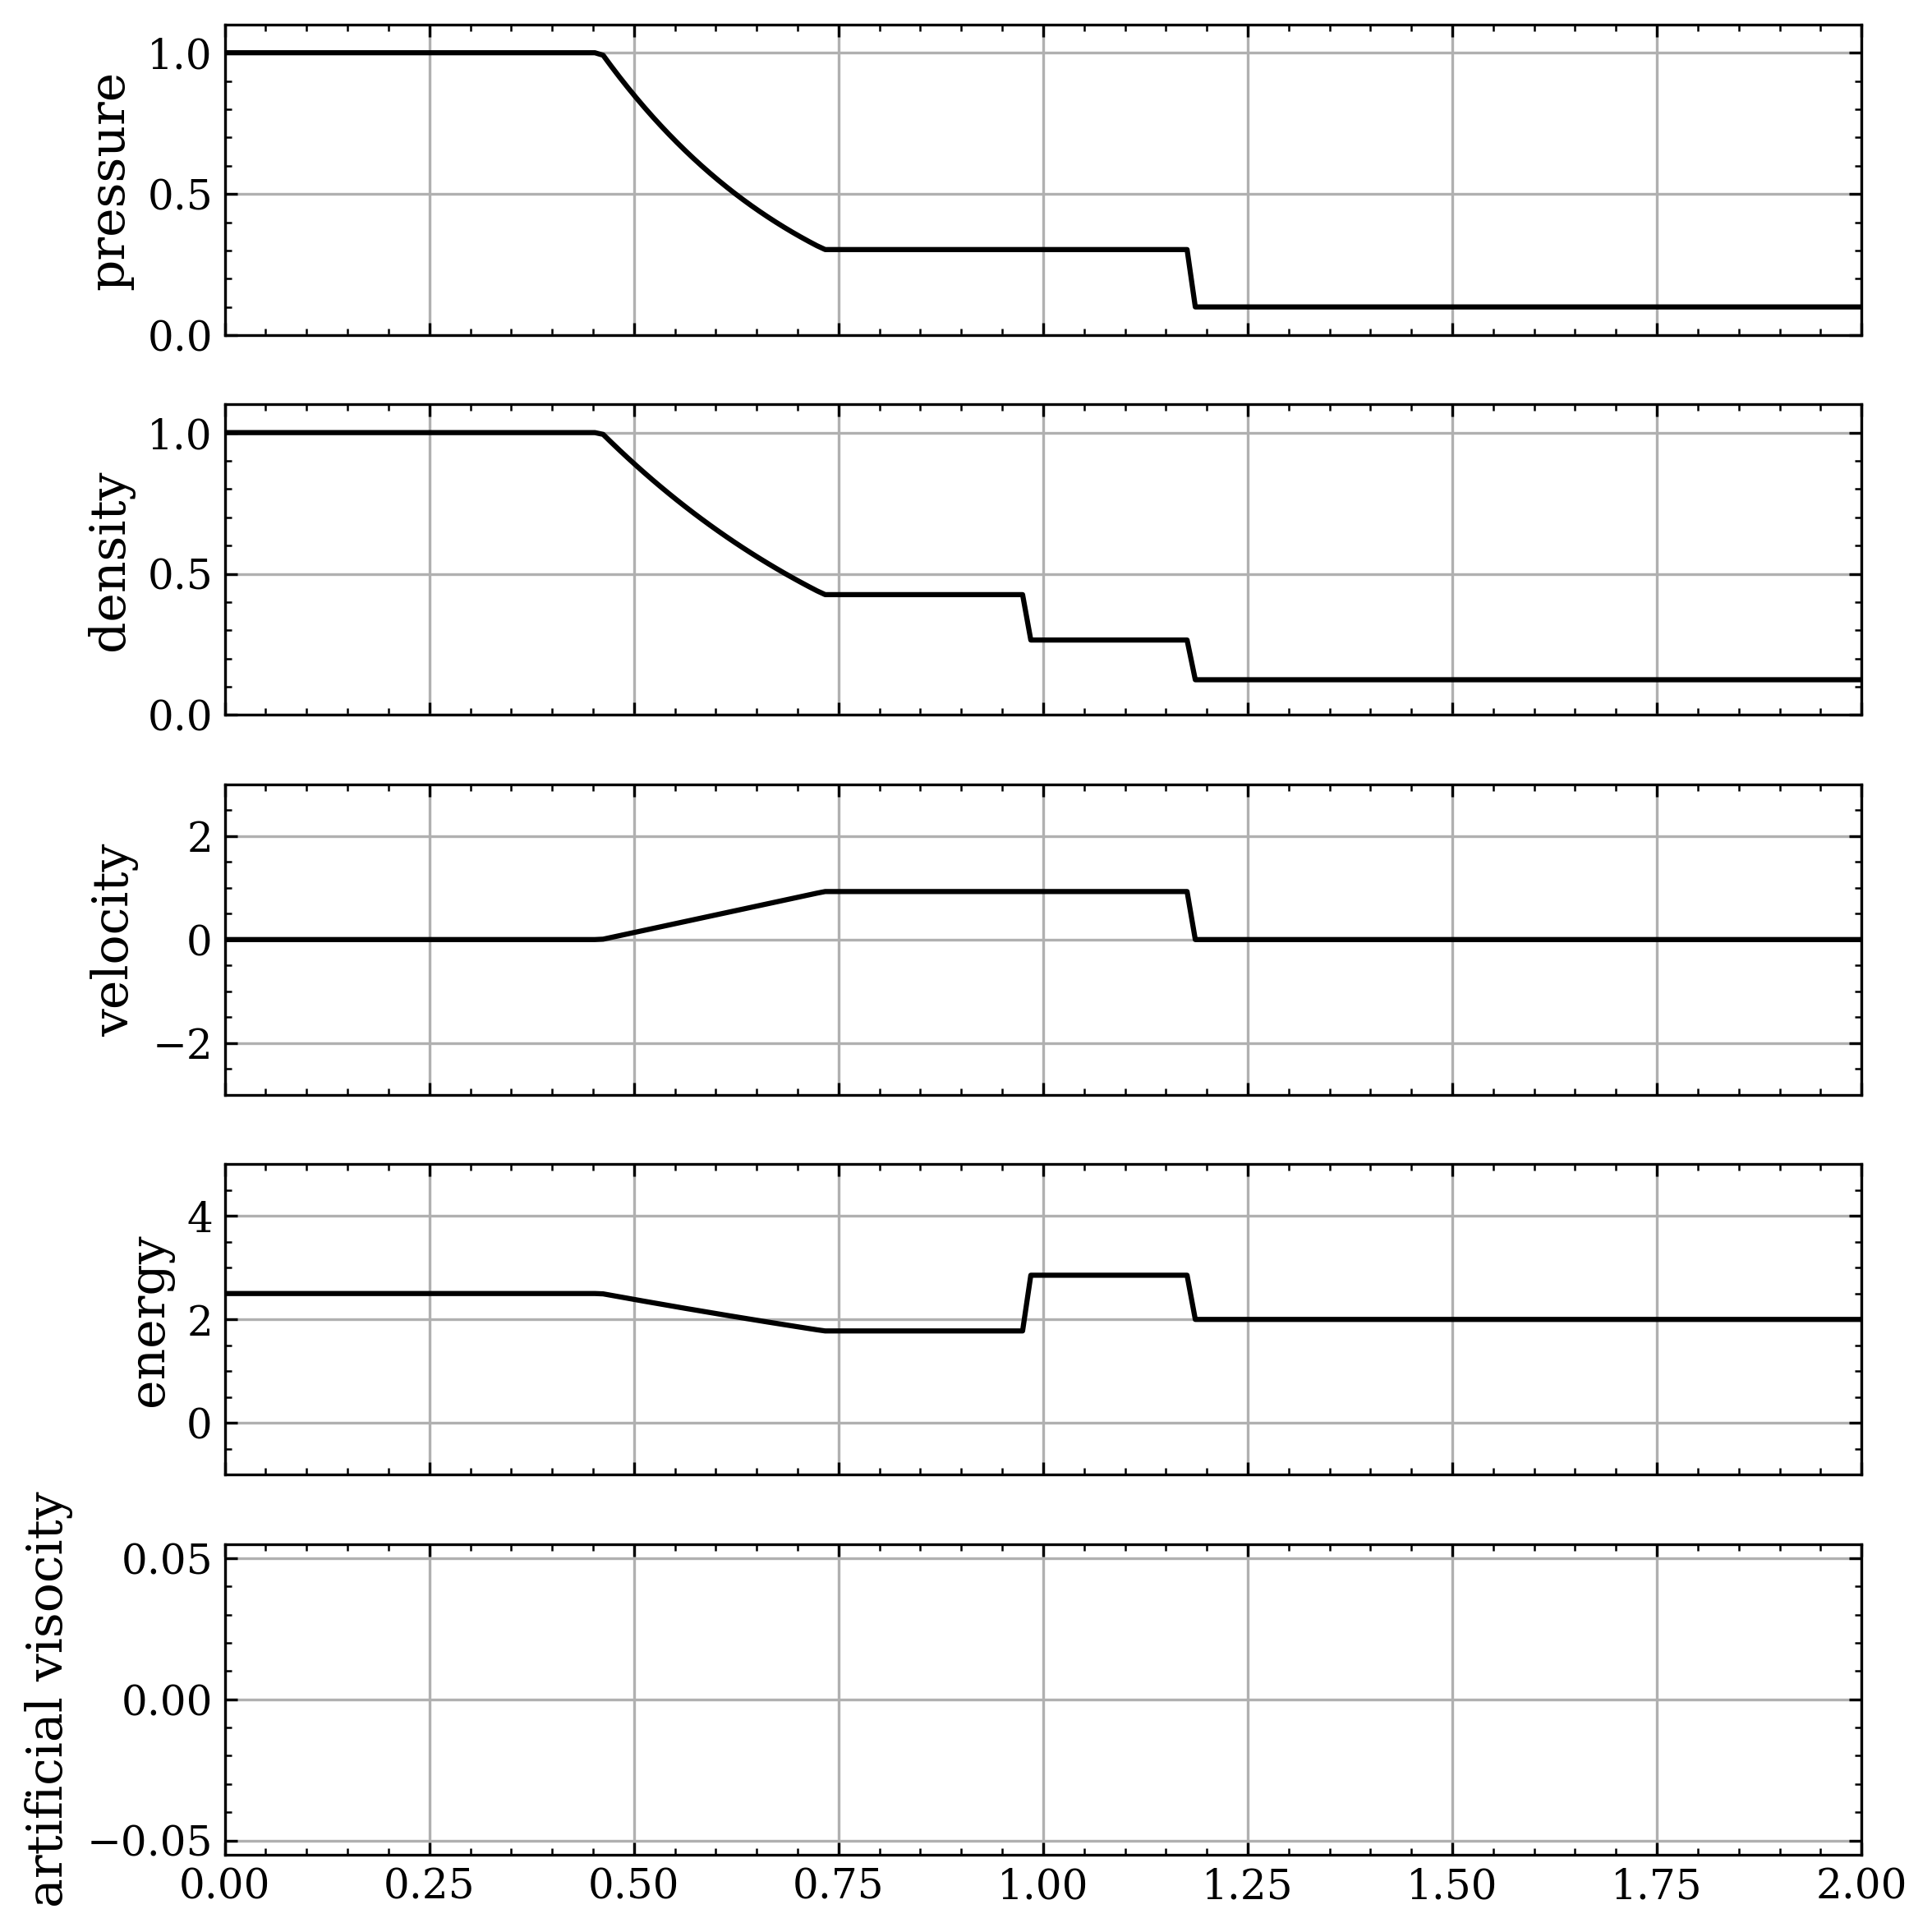

In [12]:
shock_tube_numerical(N=200,tmax=0.245,verbose=False)

b) Simple numerical schemes are prone to certain artifacts near the shock interface. What
deviations from the analytic solution do you notice? What numerical improvements would
you apply to address them?

There are deviations at the shock interface where the values go somewhat non-physical, where for example, the density dips down severely. The shocks are not modeled well as discontinuities, and instead appear to be continuous. Two ideas for numerical improvements is to implement a higher order accurate scheme, and to include conservation equations to limit the solutions to physical results.

c) Check the shock solution for $N = 100$, $200$ and $400$ grid cells. How quickly is the solution
converging? Is this consistent with your expectations?

/var/folders/pg/yy4jmlqx6jdd_b30vyvvg93h0000gq/T/ipykernel_16946/2397638180.py:82: RuntimeWarning: invalid value encountered in sqrt
  cs_new = np.sqrt(gamma*pr_old/rho_old)


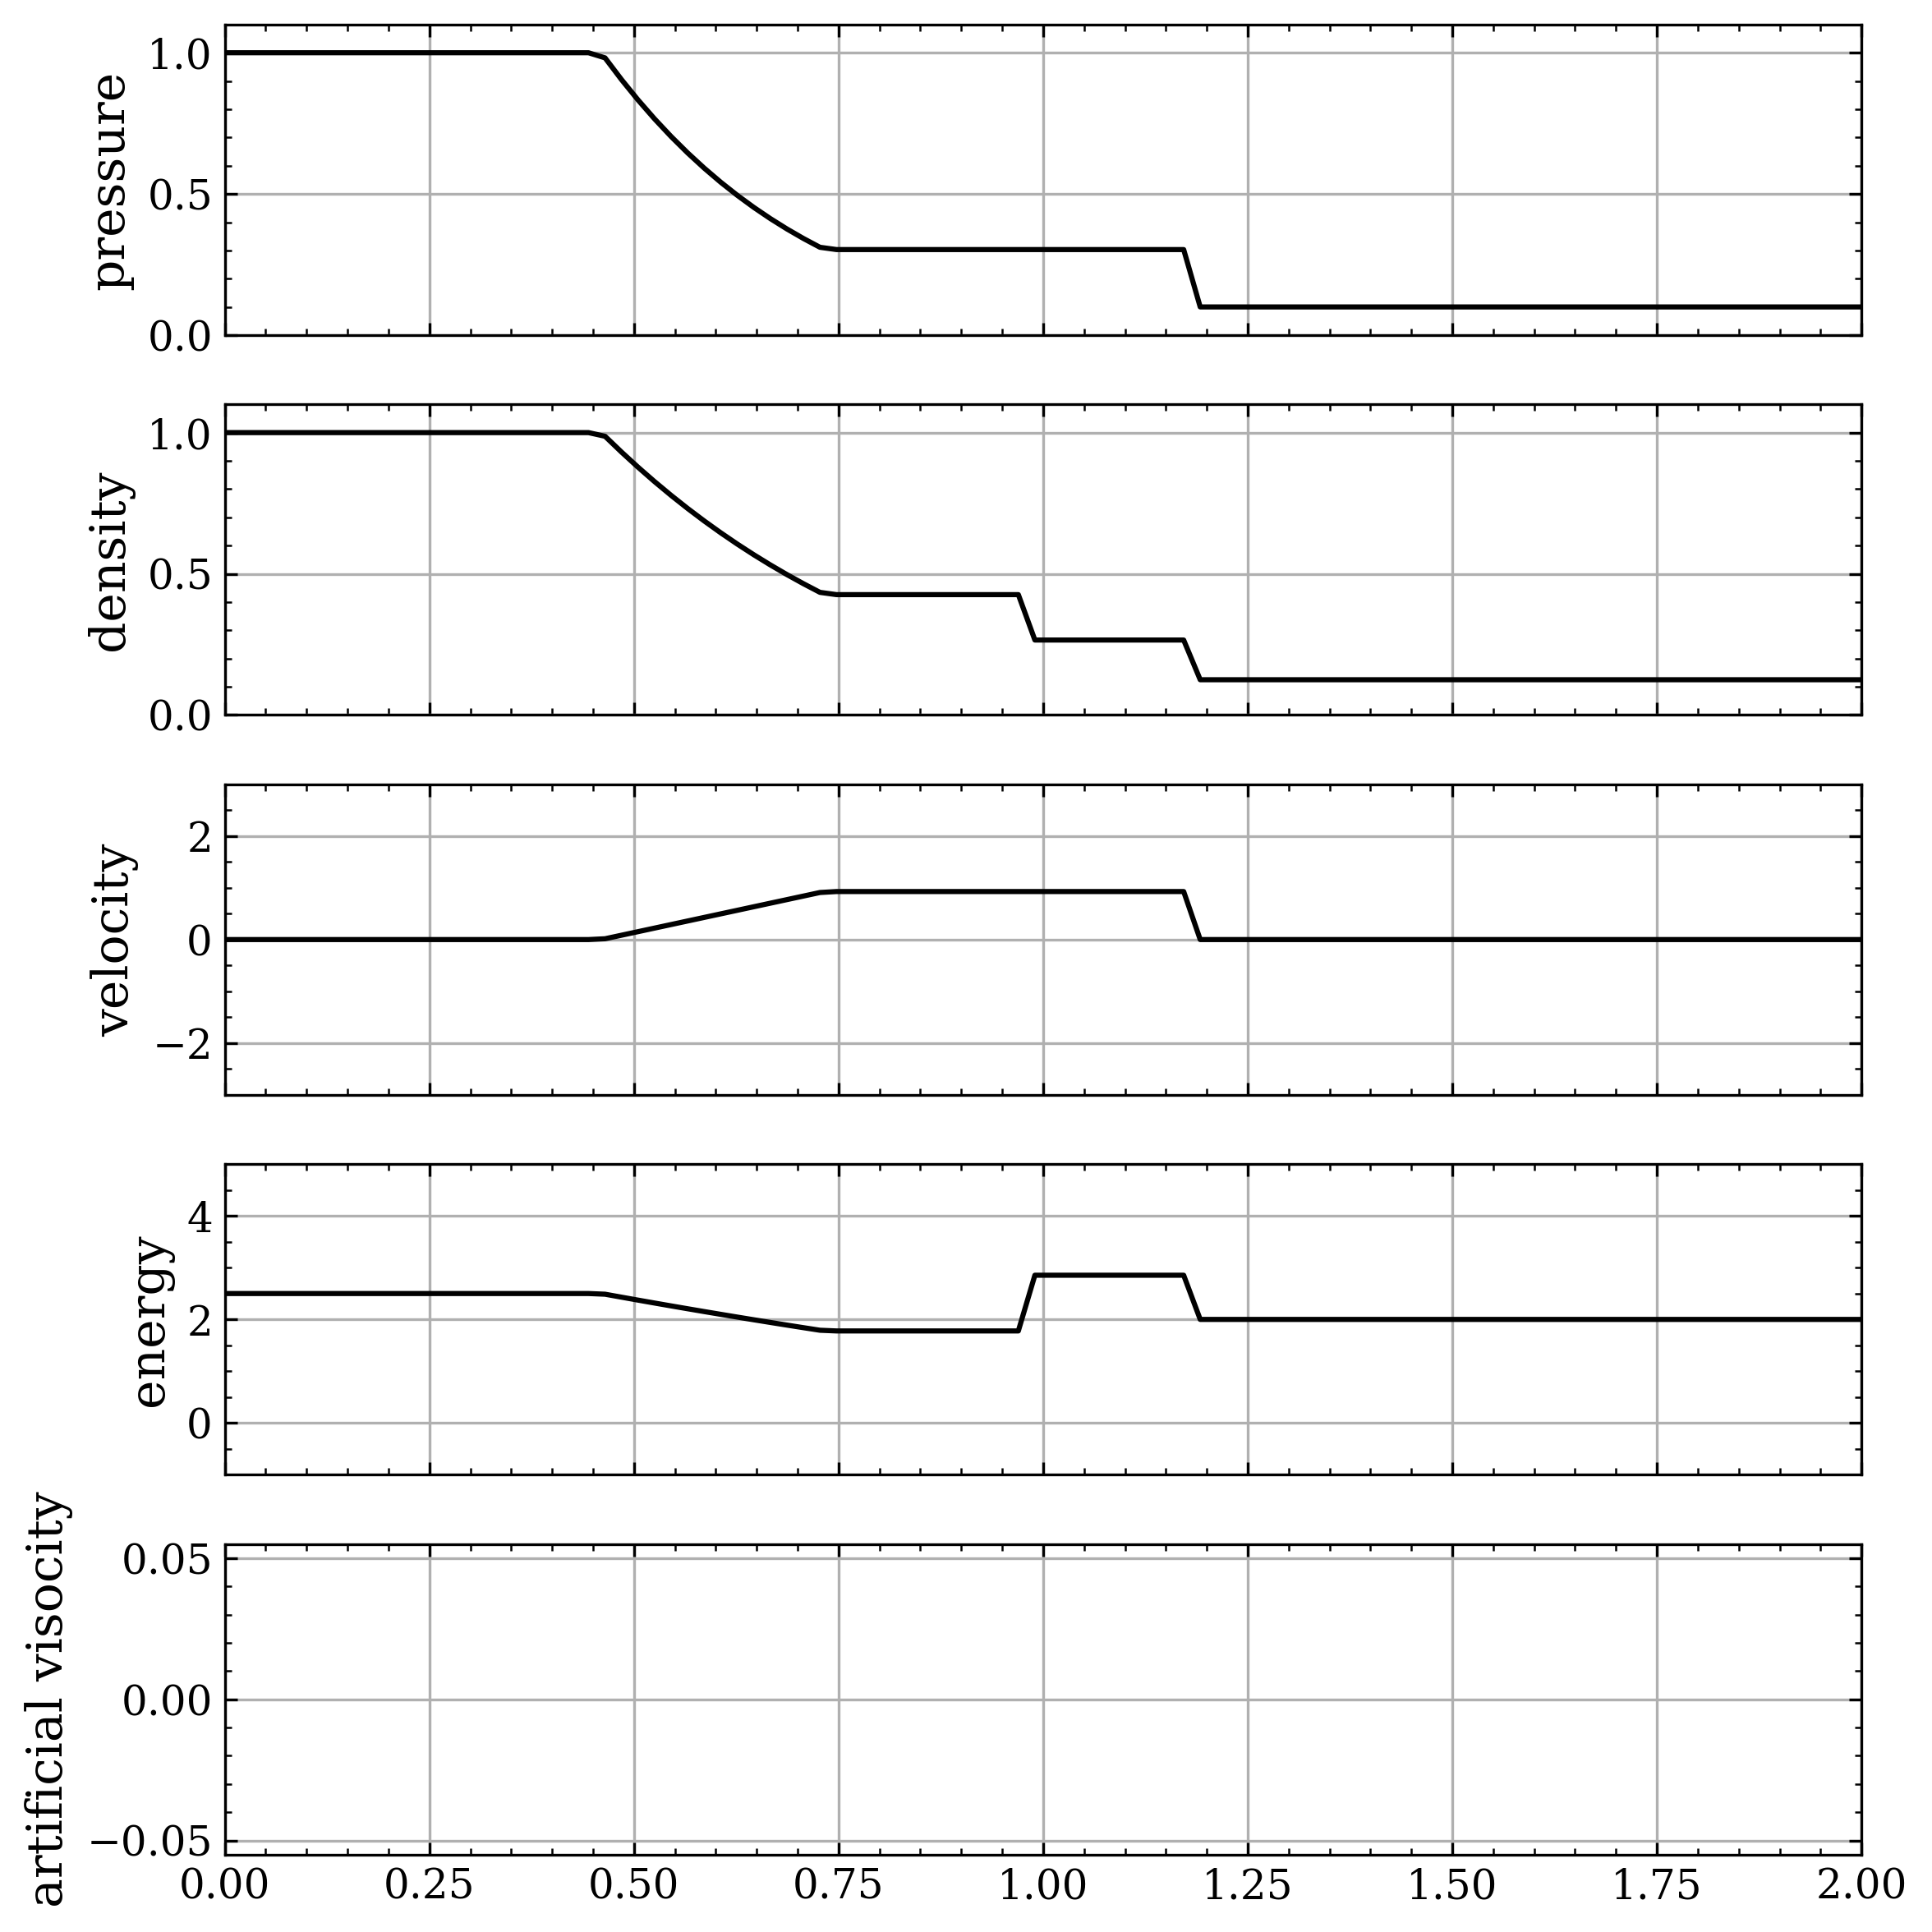

In [4]:
shock_tube_numerical(N=100,verbose=False)

/var/folders/pg/yy4jmlqx6jdd_b30vyvvg93h0000gq/T/ipykernel_16946/2397638180.py:82: RuntimeWarning: invalid value encountered in sqrt
  cs_new = np.sqrt(gamma*pr_old/rho_old)


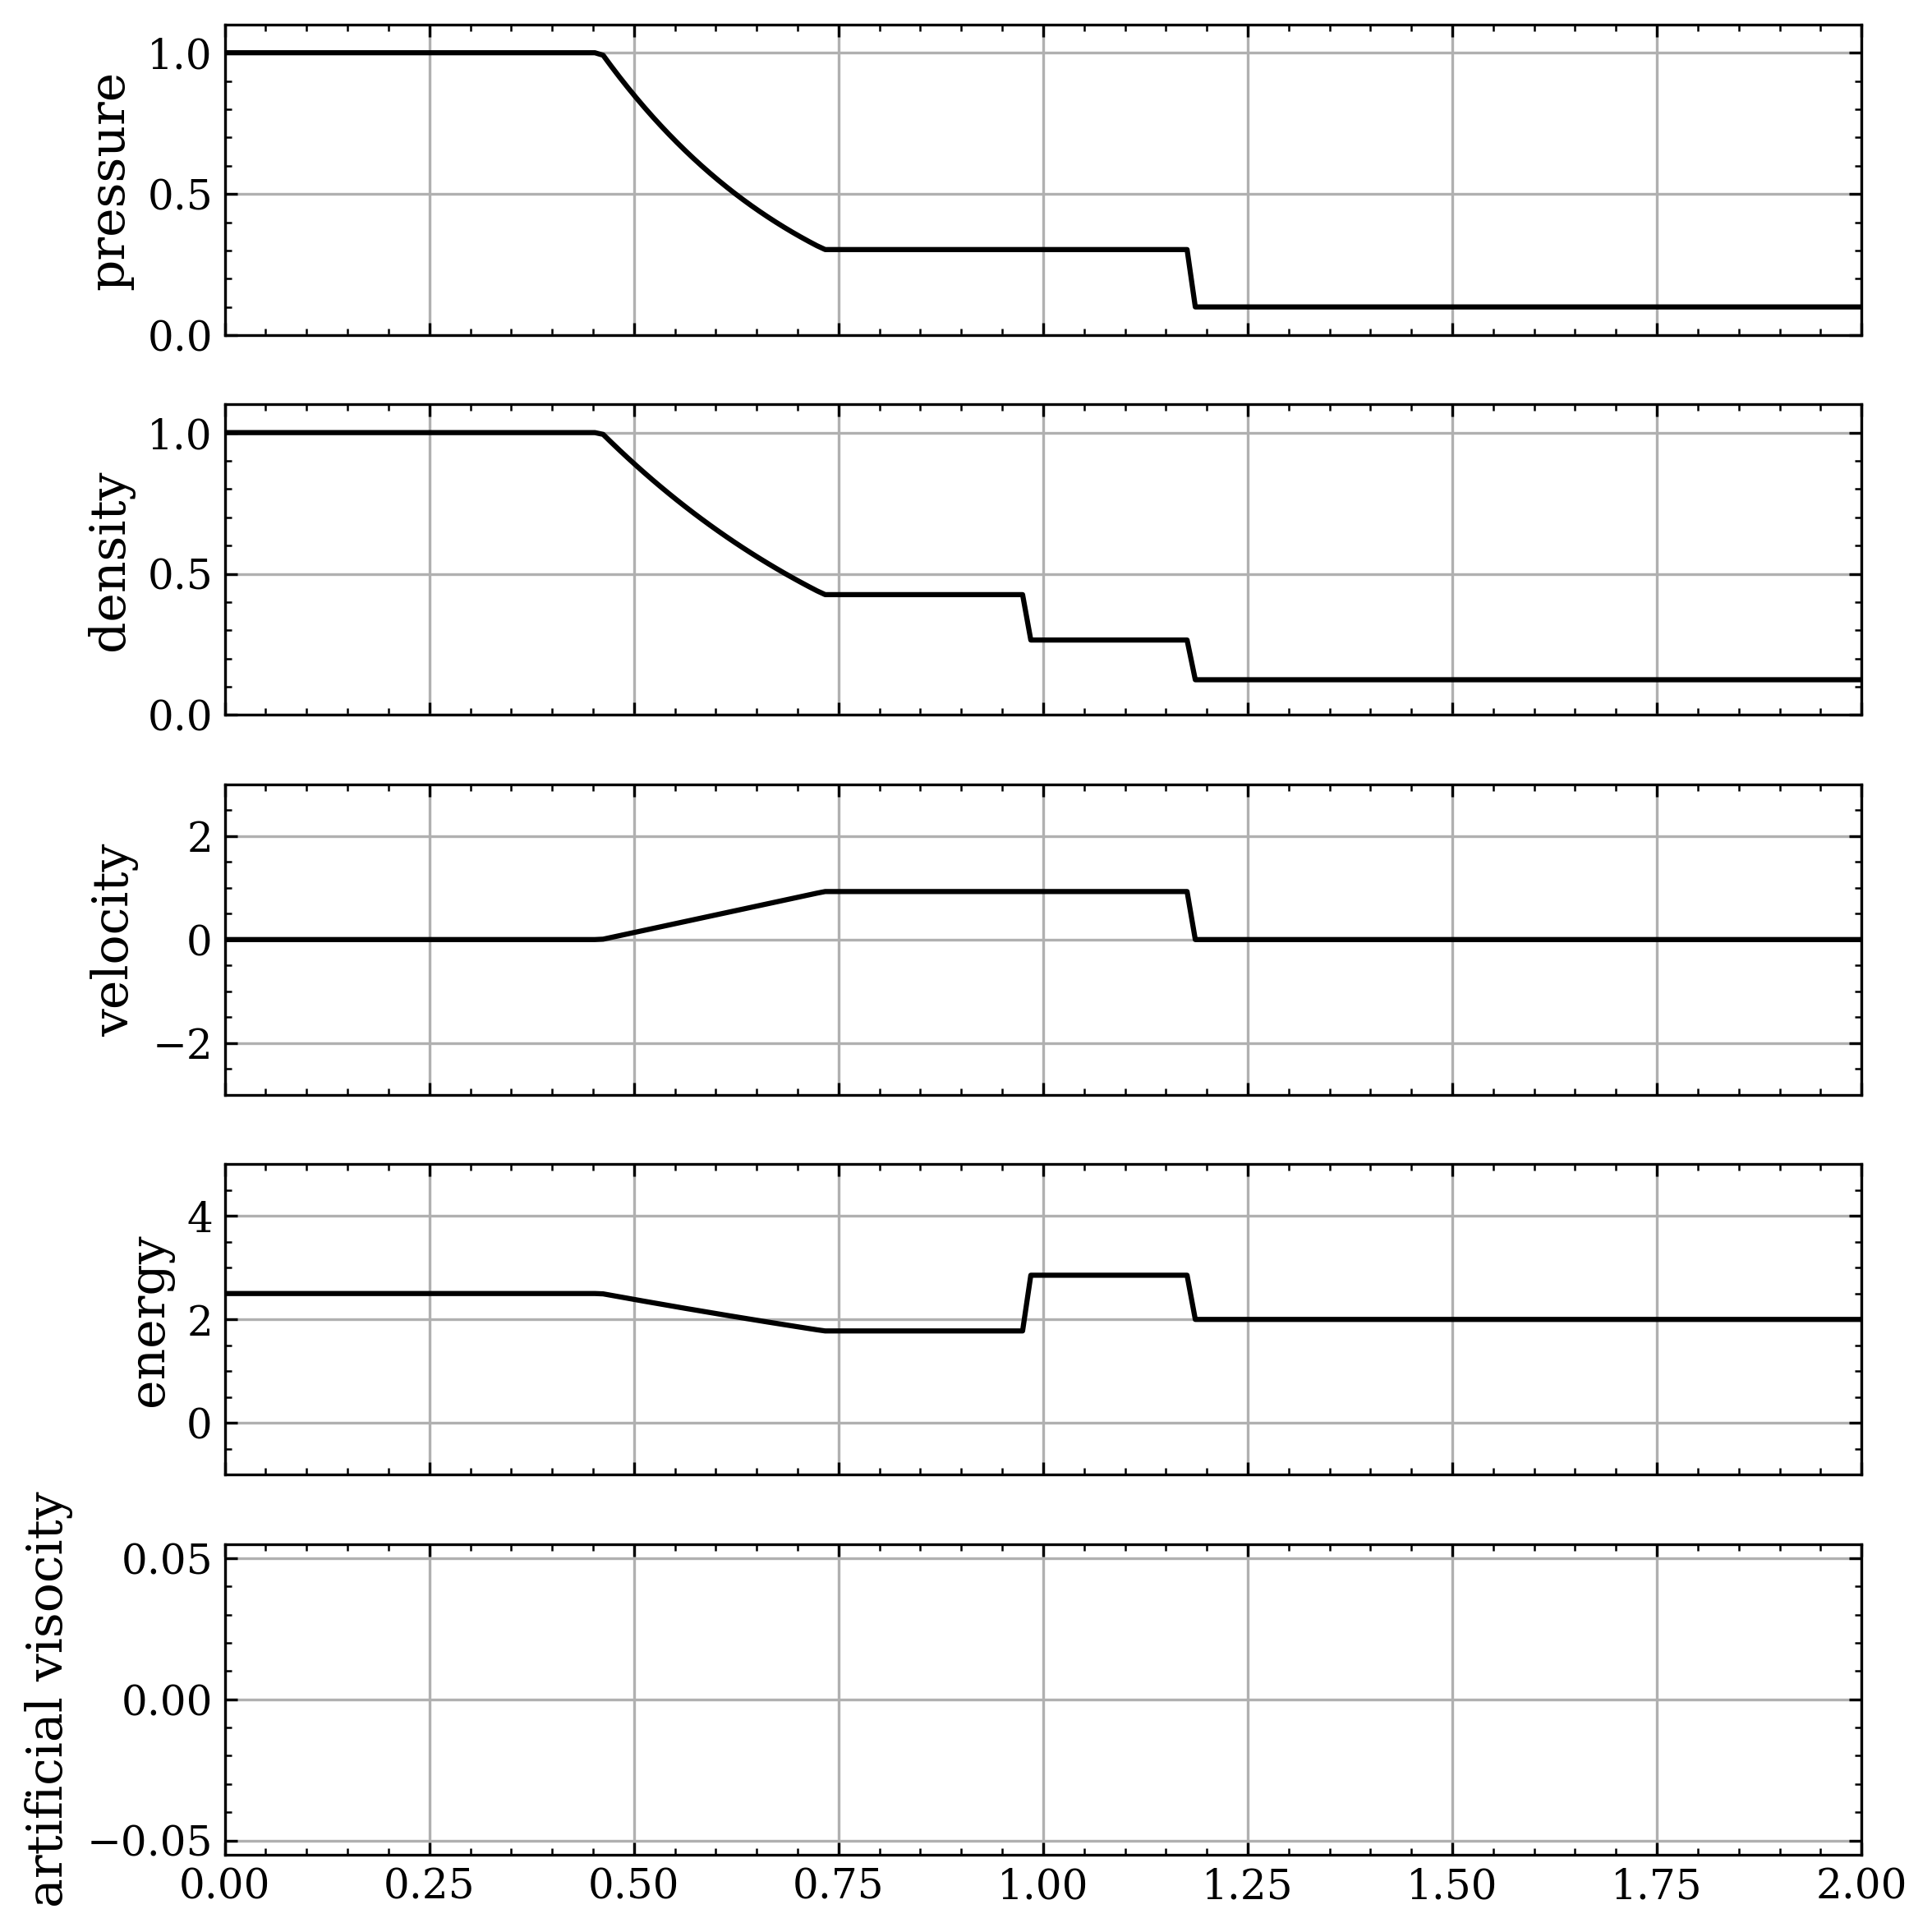

In [5]:
shock_tube_numerical(N=200,verbose=False)

/var/folders/pg/yy4jmlqx6jdd_b30vyvvg93h0000gq/T/ipykernel_16946/2397638180.py:82: RuntimeWarning: invalid value encountered in sqrt
  cs_new = np.sqrt(gamma*pr_old/rho_old)


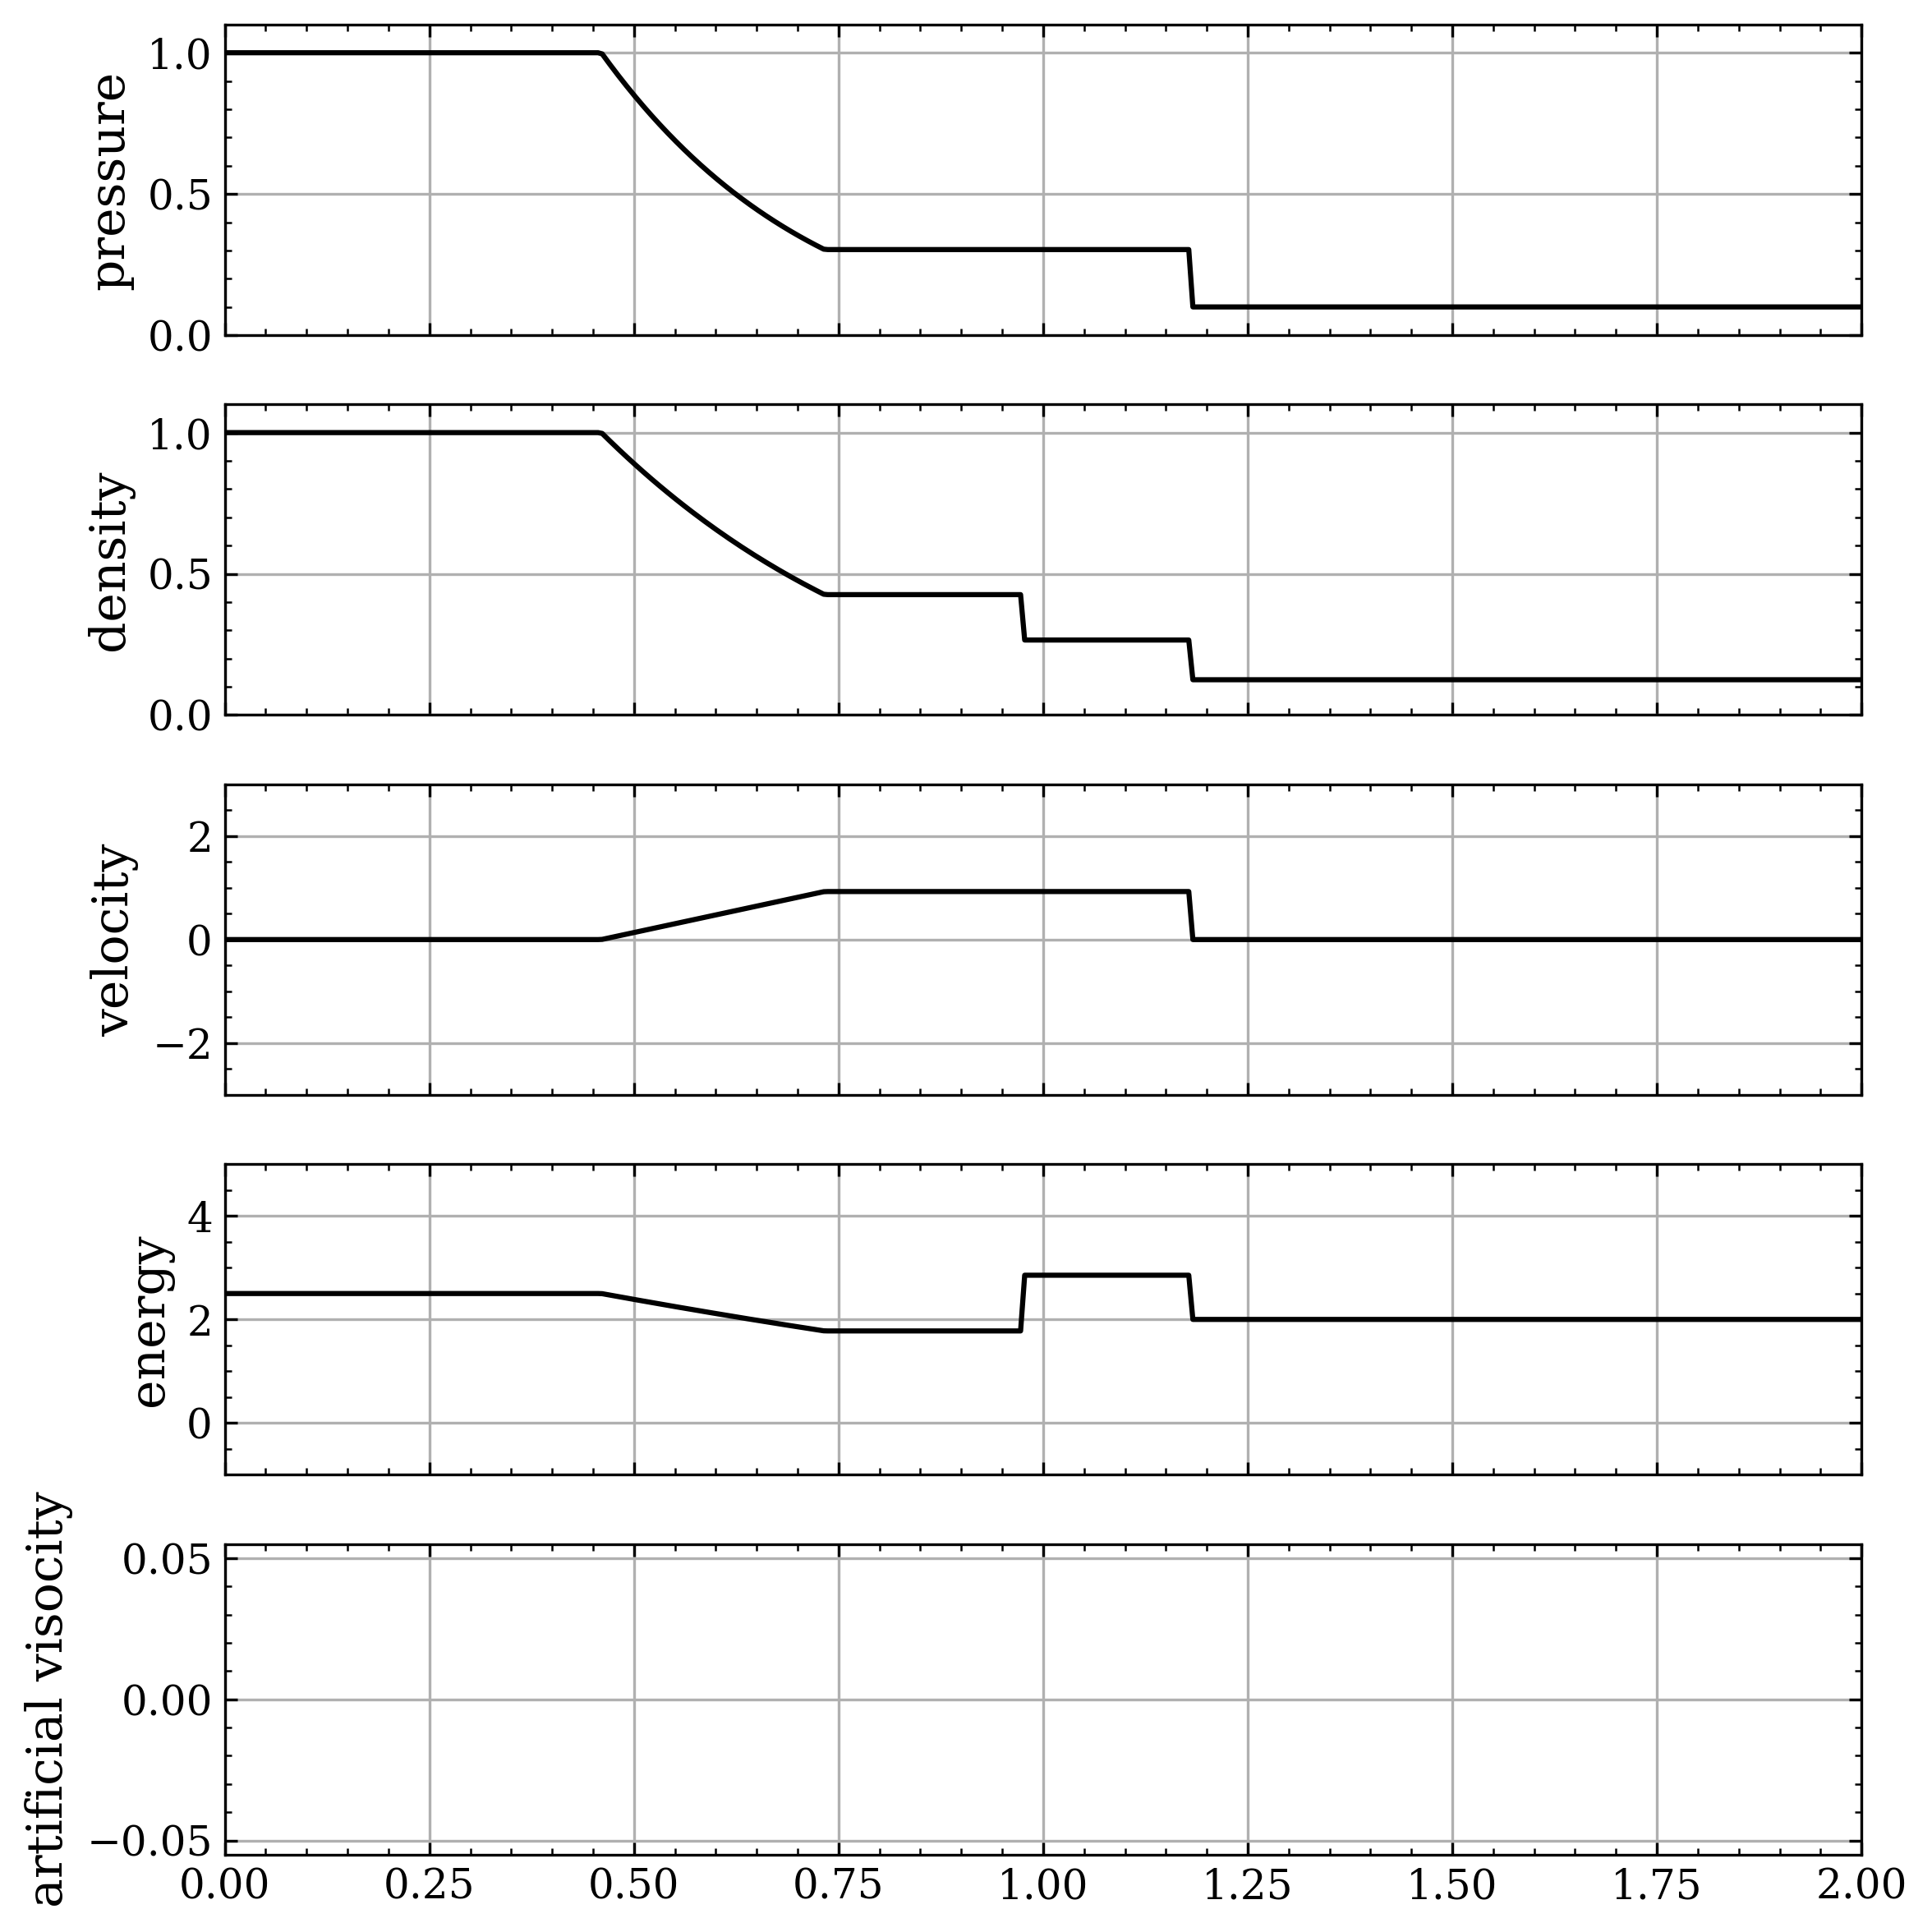

In [6]:
shock_tube_numerical(N=400,verbose=False)

The solution converges more quickly for higher $N$, but still struggles somewhat at the shock interface. With a higher $N$, we can also model a steeper shock interface at the initial conditions step since the spacing between the two levels is smaller.

d) Decrease the CFL number to $0.25$ and increase it to $1.1$. What happens to the shock
solution in each case?

/var/folders/pg/yy4jmlqx6jdd_b30vyvvg93h0000gq/T/ipykernel_16946/2397638180.py:82: RuntimeWarning: invalid value encountered in sqrt
  cs_new = np.sqrt(gamma*pr_old/rho_old)


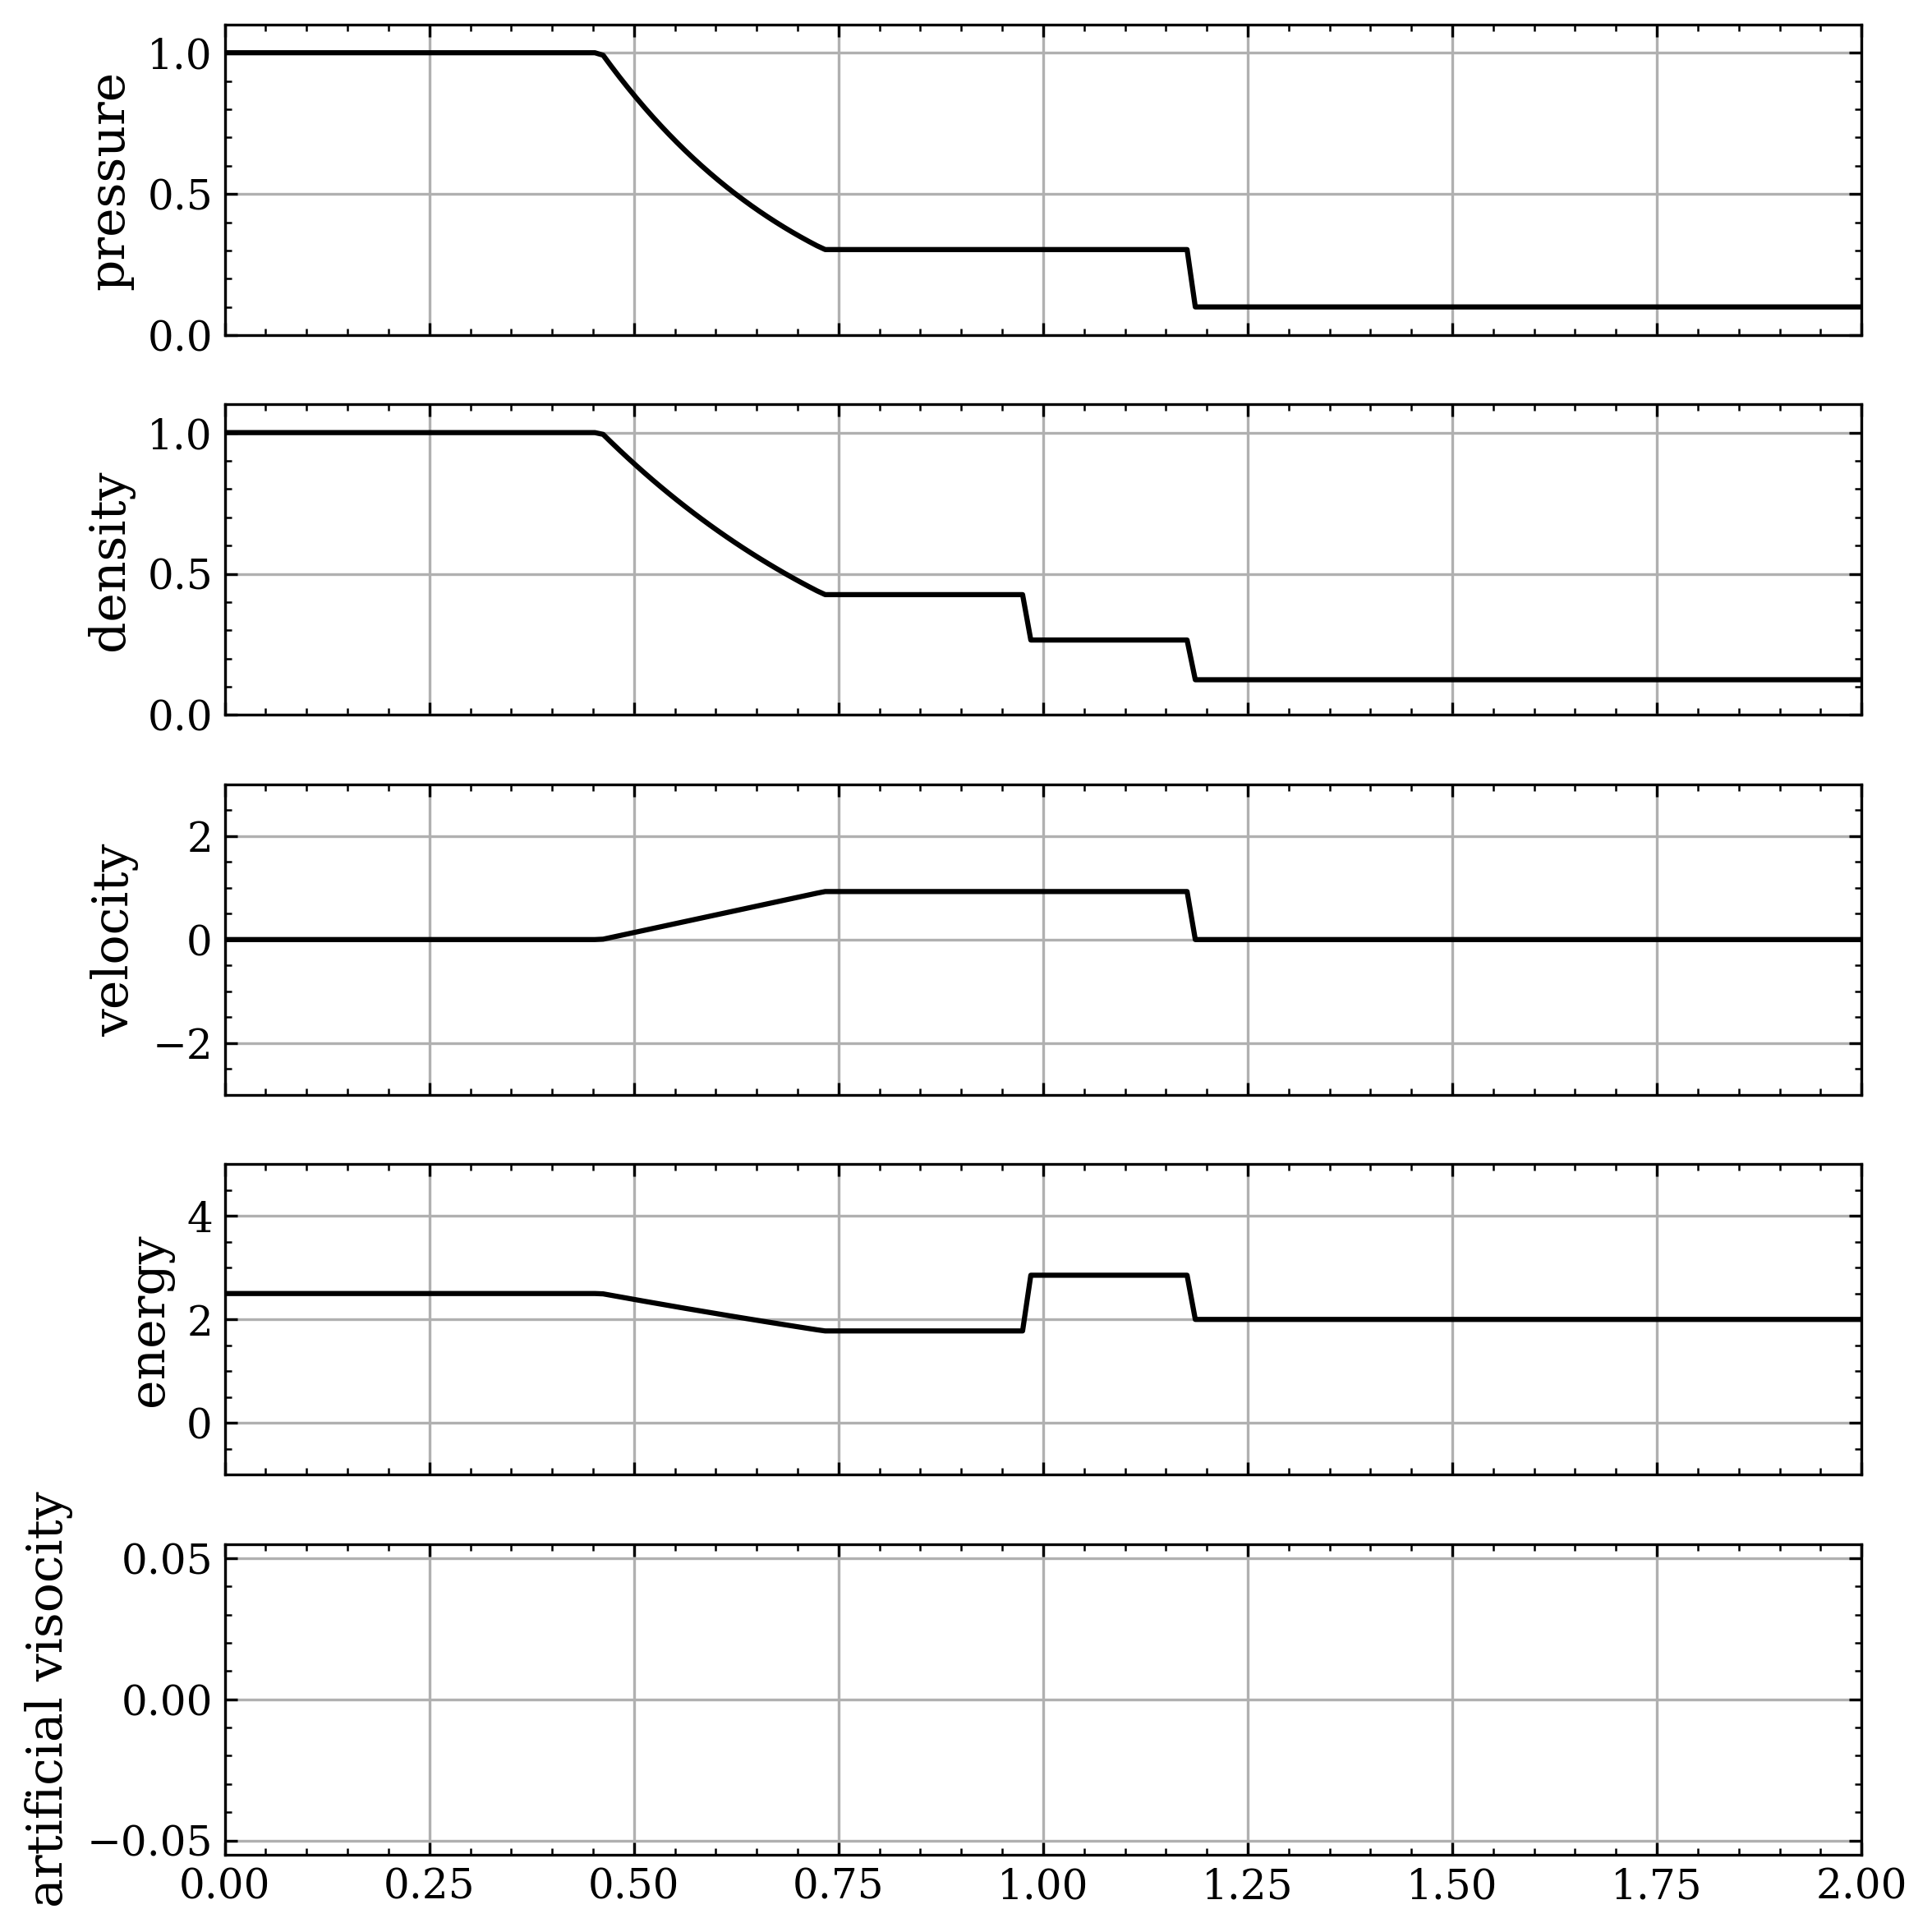

In [7]:
shock_tube_numerical(CFL=0.25,verbose=False)

/var/folders/pg/yy4jmlqx6jdd_b30vyvvg93h0000gq/T/ipykernel_16946/2397638180.py:82: RuntimeWarning: invalid value encountered in sqrt
  cs_new = np.sqrt(gamma*pr_old/rho_old)


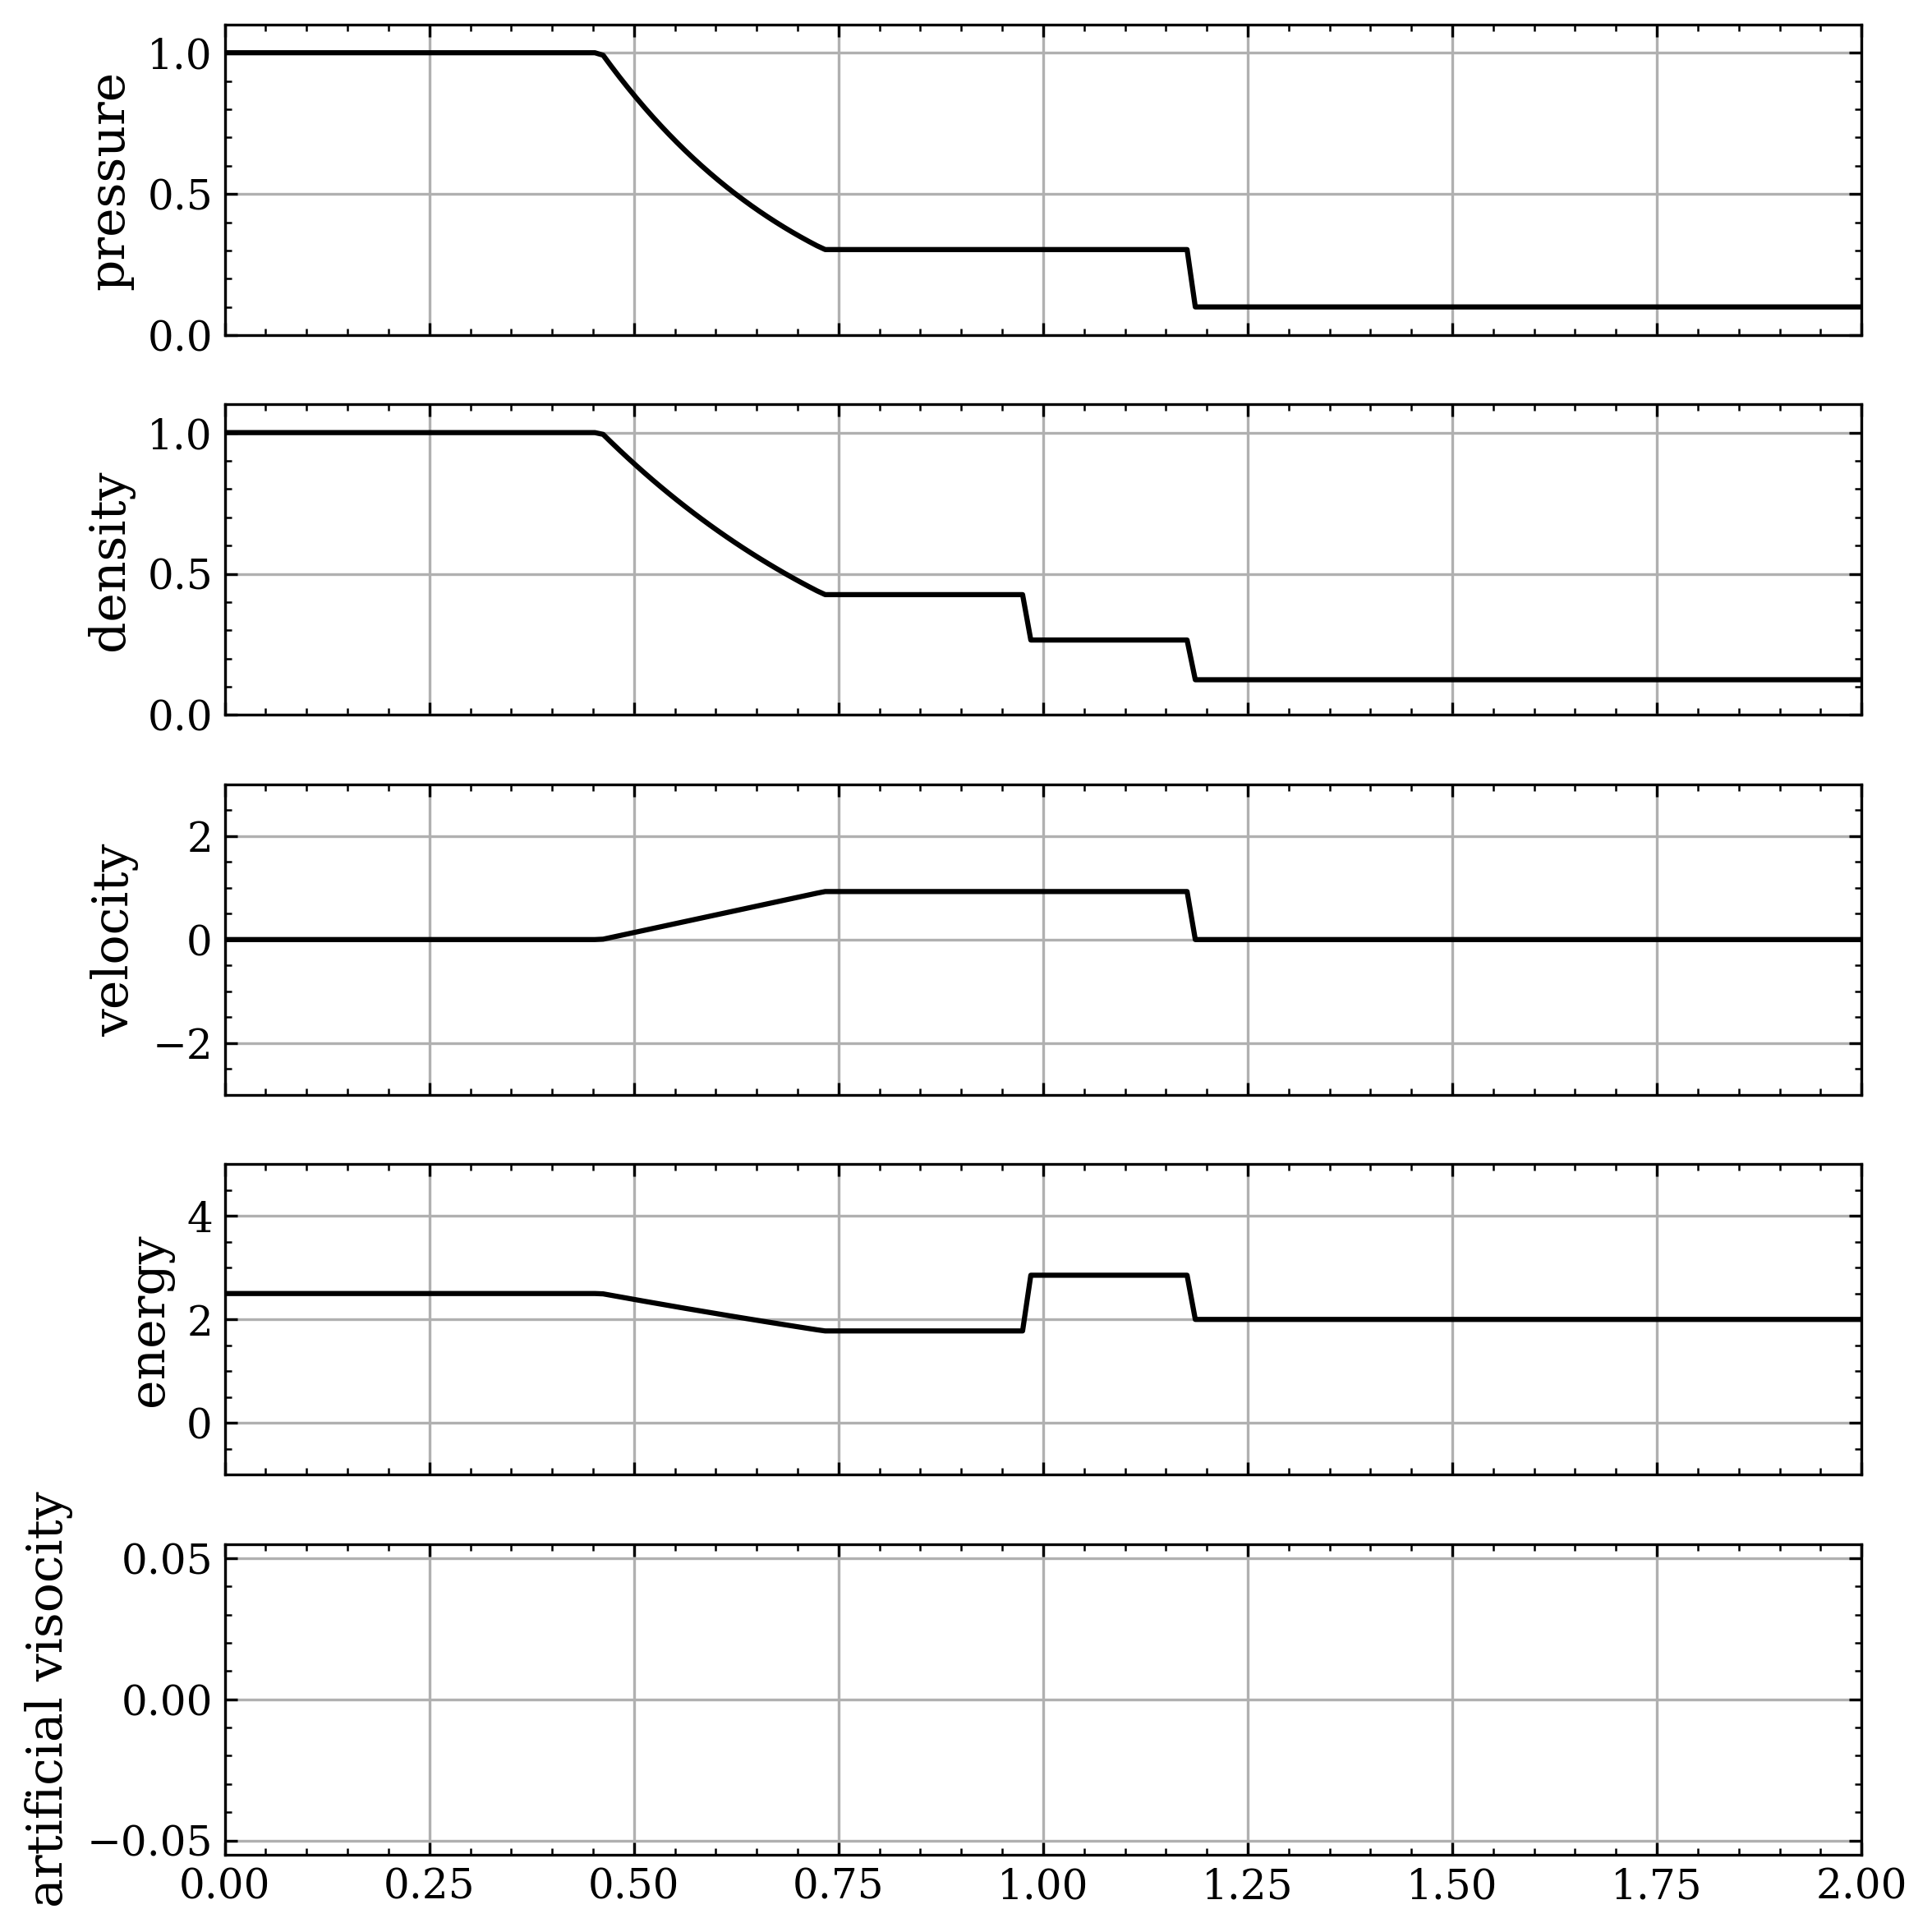

In [8]:
shock_tube_numerical(CFL=1.1,verbose=False)

e) Evaluate how sensitive the solution is to magnitude of the coefficient of artificial viscosity.
Increase the viscosity coefficients by a factor of 2 and decrease them by a factor of 2. How
does the solution change? What impact do the two different viscous components have on
the solution?

/var/folders/pg/yy4jmlqx6jdd_b30vyvvg93h0000gq/T/ipykernel_16946/2397638180.py:82: RuntimeWarning: invalid value encountered in sqrt
  cs_new = np.sqrt(gamma*pr_old/rho_old)


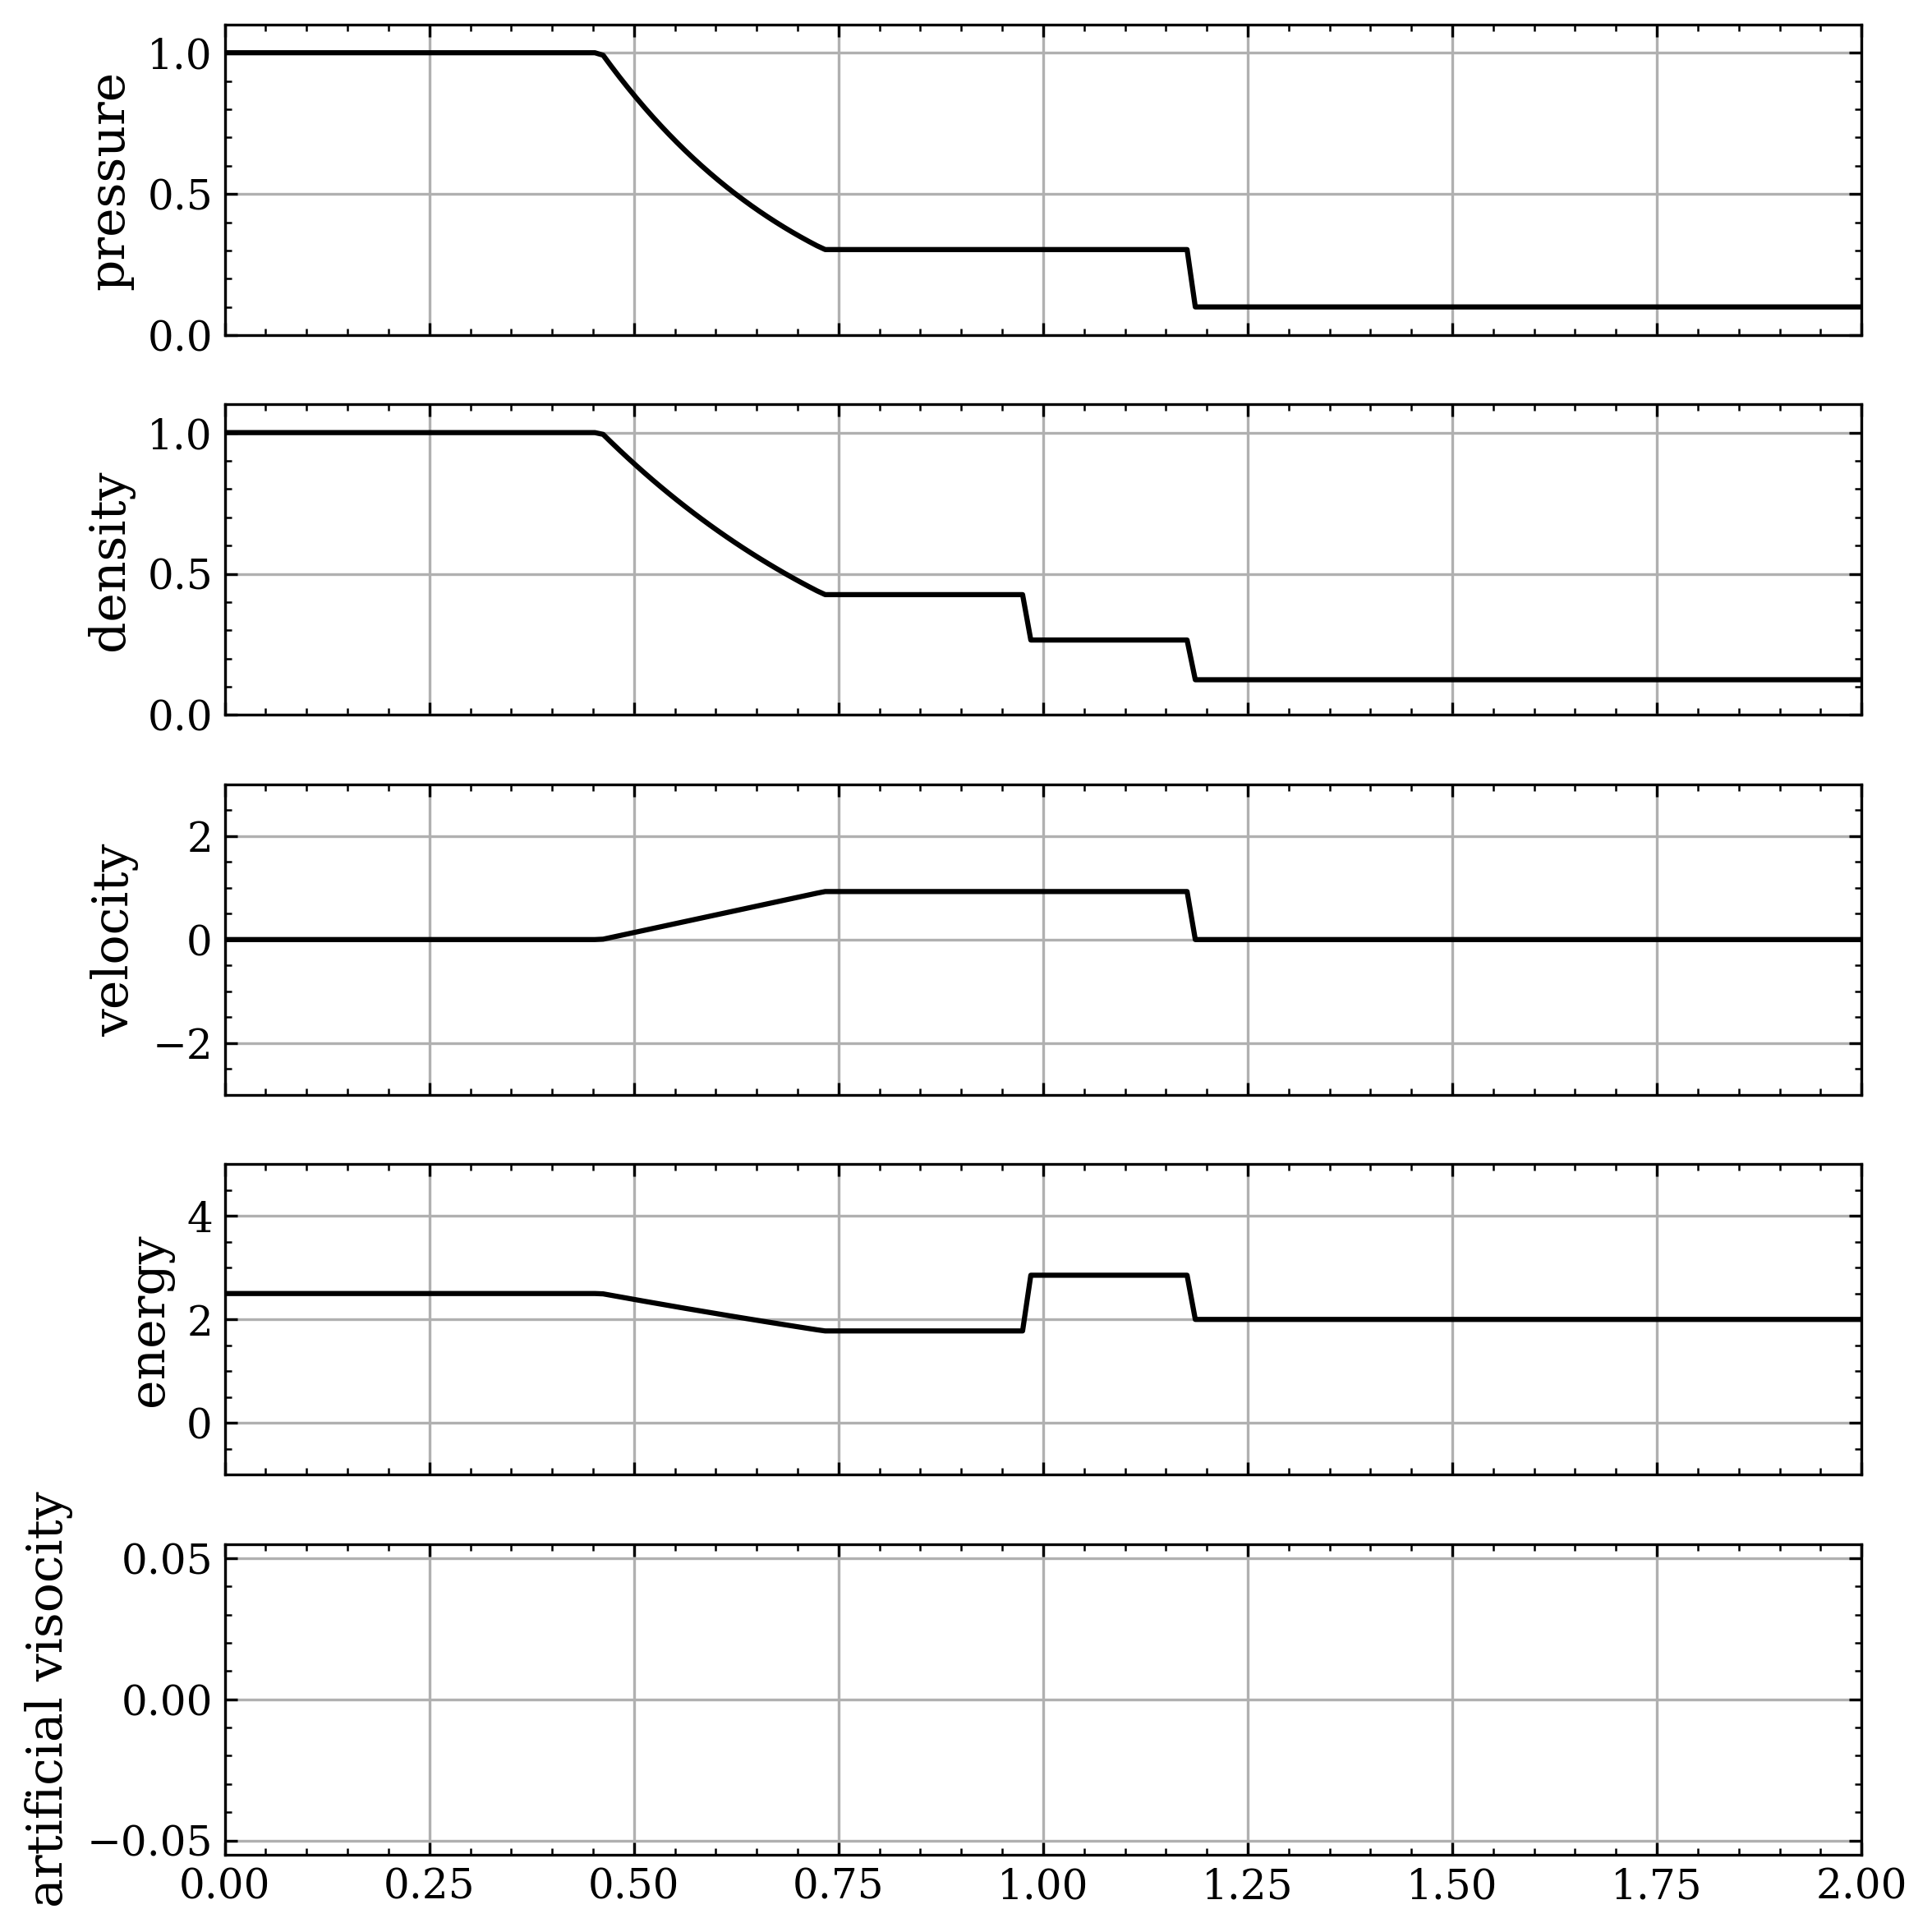

In [9]:
shock_tube_numerical(q0=8,q1=1,verbose=False)

/var/folders/pg/yy4jmlqx6jdd_b30vyvvg93h0000gq/T/ipykernel_16946/2397638180.py:82: RuntimeWarning: invalid value encountered in sqrt
  cs_new = np.sqrt(gamma*pr_old/rho_old)


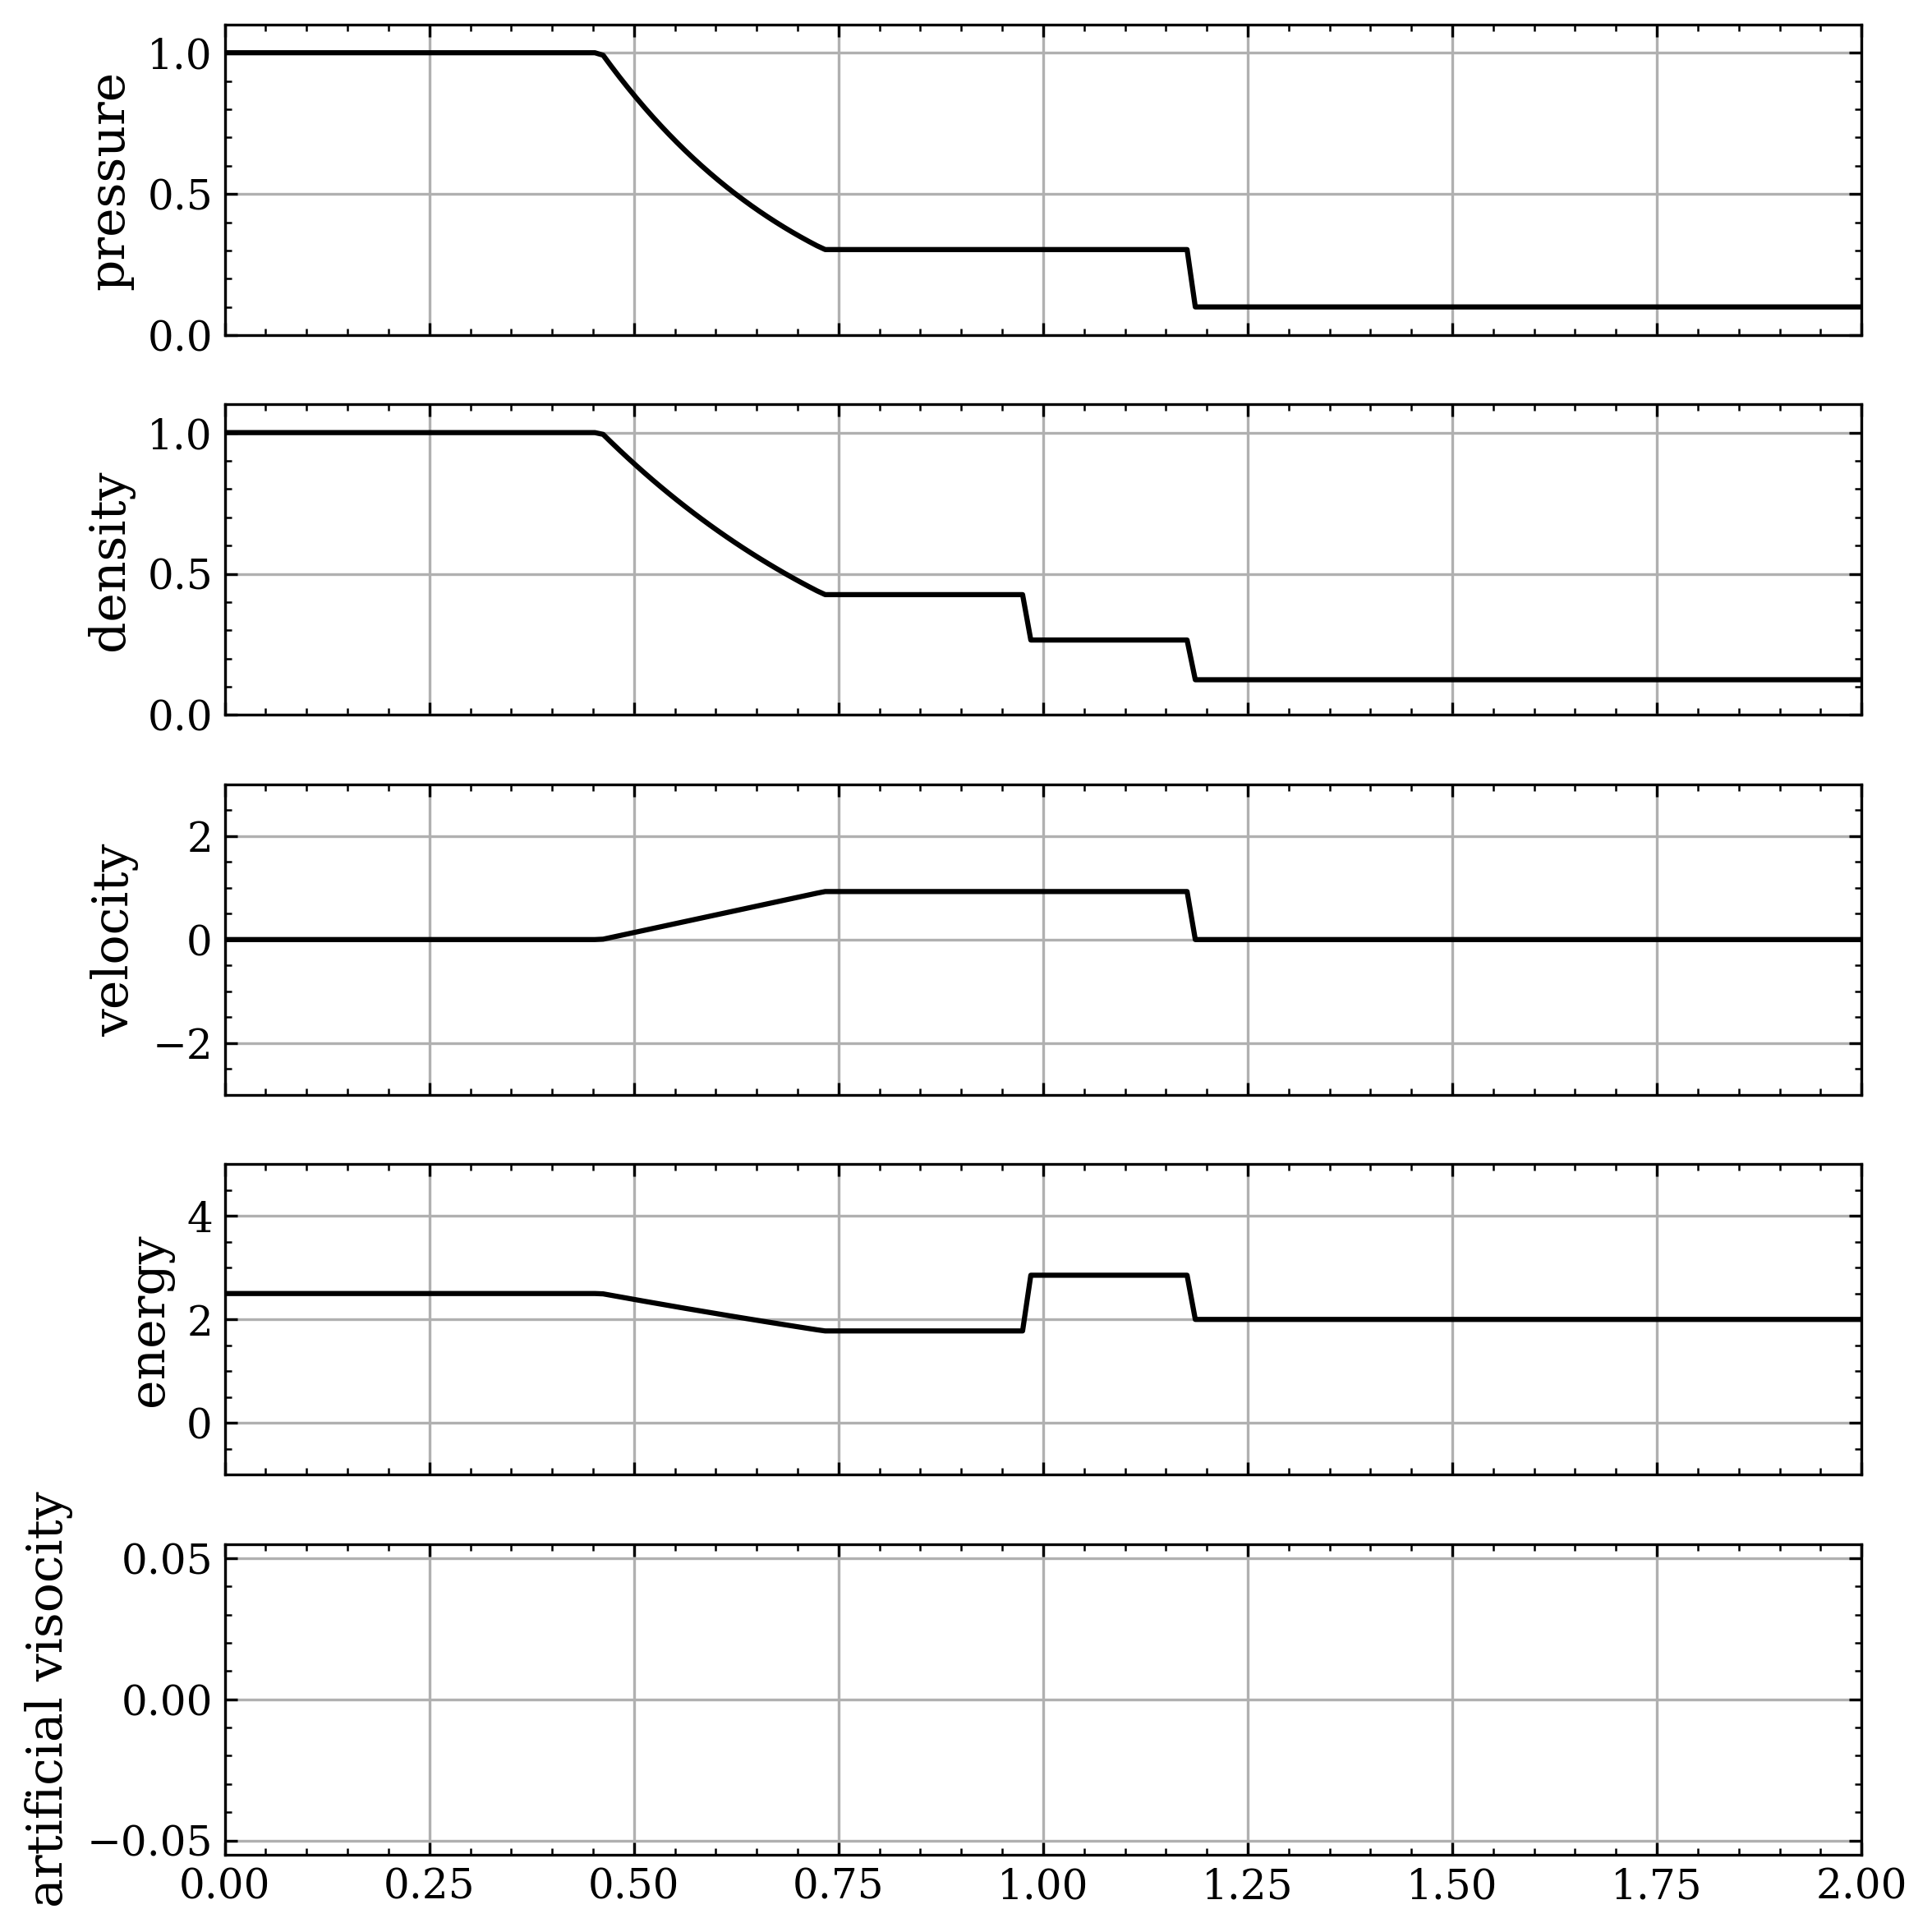

In [10]:
shock_tube_numerical(q0=2,q1=0.25,verbose=False)